In [1]:
import ammolite
ammolite.launch_pymol()

In [2]:
# Import modules from biotite
from tempfile import gettempdir
import biotite.database.entrez as entrez
import biotite.sequence.io.fasta as fasta
import biotite.sequence as seq
import biotite.application.clustalo as clustalo
import biotite.sequence.graphics as graphics

# Import modules from BioPython
from Bio import AlignIO
from Bio import SeqIO
from Bio.Align.Applications import ClustalOmegaCommandline

#Import generic modules
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
#Generate list of protein accession codes from txt file.
data = open('/Users/oliverpowell/Dropbox/Python/Project_Lottie/Data/brca1_accession_codes.txt', 'r')
protein_codes = []
for line in data:
    accession_code = line.rstrip()
    protein_codes.append(accession_code)

labels= ['H. sapiens', 'M. musculus', 'R. norvegicus', 'C. familiaris', 'P. troglodytes', 'M. mulatta', 'B. taurus', 'G. gorilla']

In [13]:
#Use accession codes to obtain sequence of each protein from NCBI and place in list
sequences = []
for protein in protein_codes:
    protein_seq = entrez.fetch(protein, gettempdir(), db_name = 'protein', ret_type='fasta', suffix='fa')
    fasta_file = fasta.FastaFile.read(protein_seq)
    tp_seq = fasta.get_sequence(fasta_file)
    sequences.append(tp_seq)

In [5]:
#Run MSA using Clustal Omega via Biotite
app = clustalo.ClustalOmegaApp(sequences)
app.start()
app.join()
alignment = app.get_alignment()

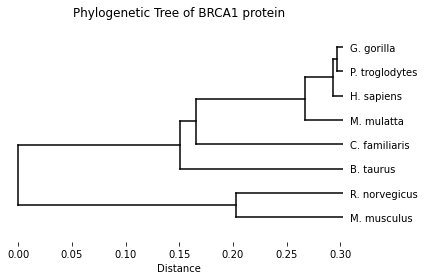

In [6]:
#Access Phylogenetic tree produced by Clustal Omega and Plot.
tree = app.get_guide_tree()
fig, ax = plt.subplots()
graphics.plot_dendrogram(
    ax, tree, labels= labels
)

plt.title('Phylogenetic Tree of BRCA1 protein')
ax.set_xlabel("Distance")
fig.tight_layout()
plt.savefig('Visualisations/PhylogeneticTree.png', dpi=1000)
plt.show()


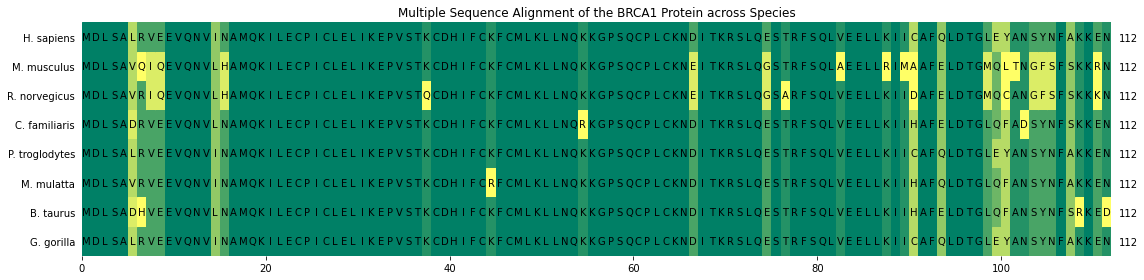

In [7]:
# Plot multiple sequence alignment from Clustal Omega (only chain A)
fig = plt.figure(figsize=(16, 4)) #50 bases = 8 inches, 1 row = 2 inches
ax = fig.add_subplot(111)
order = app.get_alignment_order()
graphics.plot_alignment_similarity_based(
    ax, alignment[0:112], show_numbers=True, show_line_position=True,
    cmap='summer_r', symbols_per_line=112, labels = labels
)

plt.title('Multiple Sequence Alignment of the BRCA1 Protein across Species')

plt.tight_layout()
plt.savefig('Visualisations/MSA.png', dpi=100)
plt.show()


In [8]:
# opens file containing accession codes
data = open('/Users/oliverpowell/Dropbox/Python/Project_Lottie/Data/brca1_accession_codes.txt', 'r')

# writes blank output file
file = open('/Users/oliverpowell/Dropbox/Python/Project_Lottie/Data/brca1_seqs.fa', 'w+')

# generate list of protein accession codes from file
protein_codes = []
for line in data:
    accession_code = line.rstrip()
    protein_codes.append(accession_code)

# Writes each seq to the output file in FASTA format
for protein in protein_codes:
    protein_seq = entrez.fetch(protein, gettempdir(), suffix = 'fa', db_name = 'protein', ret_type='fasta')
    fasta_file = fasta.FastaFile.read(protein_seq)
    file.write(str(fasta_file) + '\n')
file.close()
data.close()

In [9]:
# define input and output file
in_file = '/Users/oliverpowell/Dropbox/Python/Project_Lottie/Data/brca1_seqs.fa'
out_file ='/Users/oliverpowell/Dropbox/Python/Project_Lottie/Data/brca1_output.fa'

# get the command for Clustal Omega
clustal = ClustalOmegaCommandline(infile = in_file, outfile = out_file, auto = False, force=True, outfmt = 'fasta')
os.system(str(clustal))

0

In [10]:
#Read alignment FASTA files
alignment = AlignIO.read('/Users/oliverpowell/Dropbox/Python/Project_Lottie/Data/brca1_output.fa', 'fasta')

In [11]:
# Generate 2d numpy array of aligned sequences
align_array = []
for ali in alignment:
    seq_array = np.asarray(ali.seq[0:109])
    align_array.append(seq_array)

align_array2d = np.asarray(align_array)

# Scans alignment data and records conserved residue positions in a list, each column of the array is scanned individually.
conserved_residues = []
i = 0,1,2,3,4,5,6,7
j = 0

while j != len(ali.seq[0:109]):
    arr = align_array2d[i,j]
    result = np.all(arr == arr[0])
    if result:
        position = j+1
        conserved_residues.append(position)
    j+=1

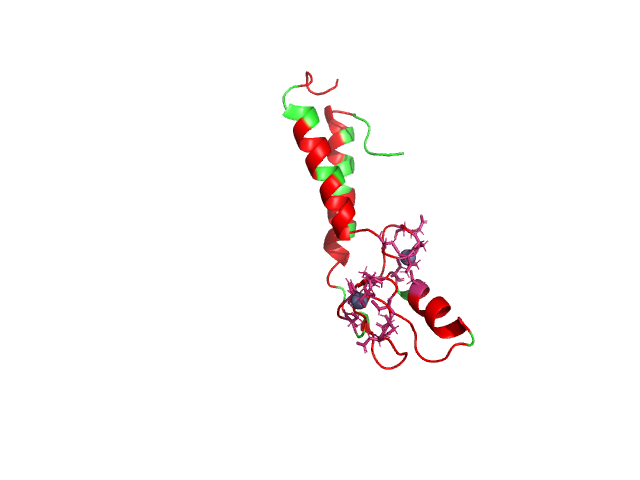

In [12]:
# Import protein file and remove irrelevant chains (BRCT)
ammolite.cmd.fetch('1jm7')
ammolite.cmd.remove('chain B')

#Sets images size
PNG_SIZE = (800, 800)

#Highlights conserved residues
i = 0


while i != len(conserved_residues):
    resi = 'resi '+ str(conserved_residues[i])
    ammolite.cmd.color('red', resi)
    i+=1

# Highlights zinc finger ring binding domains
ammolite.cmd.select('substrates', 'inorganic')
ammolite.cmd.select('act_sites', 'byres substrates around 2.5')
ammolite.cmd.color('warmpink','act_sites' )
ammolite.cmd.show('sticks', 'act_sites')

# Saves protein as a PyMol Session file
ammolite.cmd.save('data/brca1_protein.pse')
ammolite.show()